# In this notebook a complete simulation will be run

In [6]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from recommender.indicator import Indicator
import recommender.indicator_functions as indf

total_data_df = pd.read_pickle('../../data/data_df.pkl')
SYMBOL = 'AAPL'
data_df = total_data_df[SYMBOL].unstack()
data_df.head()

feature,Close,High,Low,Open,Volume
date,,,,,
1993-01-29,2.12,2.19,2.11,0.0,66525200.0
1993-02-01,2.19,2.19,2.12,0.0,60138400.0
1993-02-02,2.15,2.20,2.15,0.0,45584000.0
1993-02-03,2.14,2.18,2.09,0.0,66046400.0
1993-02-04,2.12,2.15,2.11,0.0,52038000.0


In [8]:
close_df = total_data_df.xs('Close', level='feature')
close_df.head()

,SPY,MMM,ABT,ABBV,ACN,ATVI,AYI,ADBE,AMD,AAP,...,XEL,XRX,XLNX,XL,XYL,YHOO,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,43.94,24.50,6.88,NaN,NaN,NaN,NaN,2.59,18.75,NaN,...,22.00,14.28,2.50,NaN,NaN,NaN,NaN,NaN,10.94,NaN
1993-02-01,44.25,24.69,6.88,NaN,NaN,NaN,NaN,2.72,19.12,NaN,...,22.19,14.09,2.62,NaN,NaN,NaN,NaN,NaN,11.06,NaN
1993-02-02,44.34,24.72,6.53,NaN,NaN,NaN,NaN,2.84,20.25,NaN,...,22.06,14.09,2.64,NaN,NaN,NaN,NaN,NaN,11.12,NaN
1993-02-03,44.81,25.19,6.91,NaN,NaN,NaN,NaN,2.70,20.50,NaN,...,22.38,14.03,2.68,NaN,NaN,NaN,NaN,NaN,11.25,NaN
1993-02-04,45.00,26.06,6.84,NaN,NaN,NaN,NaN,2.73,20.12,NaN,...,22.81,14.15,2.67,NaN,NaN,NaN,NaN,NaN,11.69,NaN


In [9]:
total_data_df.head()

SPY         MMM         ABT  ABBV  ACN  ATVI  AYI  \
date       feature                                                             
1993-01-29 Open           0.00        0.00        0.00   NaN  NaN   NaN  NaN   
           High          43.97       24.62        6.88   NaN  NaN   NaN  NaN   
           Low           43.75       24.47        6.75   NaN  NaN   NaN  NaN   
           Close         43.94       24.50        6.88   NaN  NaN   NaN  NaN   
           Volume   1003200.00  1242800.00  4638400.00   NaN  NaN   NaN  NaN   

                          ADBE        AMD  AAP ...        XEL         XRX  \
date       feature                             ...                          
1993-01-29 Open           0.00       0.00  NaN ...       0.00        0.00   
           High           2.64      19.12  NaN ...      22.00       14.32   
           Low            2.56      18.62  NaN ...      21.88       13.84   
           Close          2.59      18.75  NaN ...      22.00       14.28   
           Volume   4990400.00  730600.00  NaN ...   87800.00  7633602.00   

                          XLNX  XL  XYL  YHOO  YUM  ZBH      ZION  ZTS  
date       feature                                                      
1993-01-29 Open           0.00 NaN  NaN   NaN  NaN  NaN      0.00  NaN  
           High           2.50 NaN  NaN   NaN  NaN  NaN     10.94  NaN  
           Low            2.46 NaN  NaN   NaN  NaN  NaN     10.62  NaN  
           Close          2.50 NaN  NaN   NaN  NaN  NaN     10.94  NaN  
           Volume   1745196.00 NaN  NaN   NaN  NaN  NaN  33600.00  NaN  

[5 rows x 503 columns]

In [10]:
ind1 = Indicator(indf.z_score, indf.z_score_vec, q_levels=arange(-2.0, 2.0, 0.2).tolist(), data_df=data_df)
ind2 = Indicator(indf.rsi, indf.rsi_vec, q_levels=arange(-2.0, 2.0, 0.2).tolist(), data_df=data_df)
ind3 = Indicator(indf.on_volume_balance, indf.on_volume_balance_vec, q_levels=arange(-2.0, 2.0, 0.2).tolist(), data_df=data_df)
indicators = {'ind1': ind1,
              'ind2': ind2,
              'ind3': ind3}

### A very simple environment with a simple agent

In [11]:
from recommender.environment import Environment
INITIAL_CAP = 100

env = Environment(total_data_df, indicators=indicators, initial_cap=INITIAL_CAP)

In [12]:
from recommender.agent import Agent

num_states = (len(ind1.q_levels)+1) * (len(ind2.q_levels)+1) * (len(ind3.q_levels)+1)
num_actions = 3  # Buy or sell all, or do nothing.

agent = Agent(num_states=num_states, 
              num_actions=num_actions, 
              random_actions_rate=0.98, 
              random_actions_decrease=0.999,
              dyna_iterations=20)

In [13]:
from recommender.order import Order

action_0 = [Order(['AAPL',Order.BUY, 100])]
action_1 = [Order(['AAPL',Order.SELL, 100])]
action_2 = [Order(['AAPL',Order.NOTHING, 0])]

actions = {0: action_0,
           1: action_1,
           2: action_2,}

In [14]:
data_df.index[252]

Timestamp('1994-01-27 00:00:00')

In [15]:
# Initialization

env.portfolio.set_current_date(data_df.index[252])
initial_state = env.get_state()
action = agent.play_learned_response(initial_state)

In [16]:
actions[action]

[symbol    AAPL
 order     SELL
 shares     100
 dtype: object]

In [17]:
import time
# TODO: Change N_iters to the whole period of data_df
# TODO: copy the code to a function that can be called from an outside loop.
N_iters = 5000

tic = time.time()
for i in range(N_iters):
# while X
    reward, new_state = env.get_consequences(actions[action])
    action = agent.play(reward, new_state)

# Show results
    #print('date={}\n'.format(env.portfolio.current_date))
    #print('reward={} \n\nnew_state={} \n\naction=\n{}'.format(reward, new_state, actions[action]))
    #print('-'*70 + '\n\n')
    #time.sleep(0.5)
toc = time.time()
print('Elapsed time: {}s'.format(toc-tic))


Elapsed time: 260.1241807937622s


In [18]:
env.portfolio.get_positions()

,shares,value
AAPL,-4700.0,-380324.0
CASH,-23376.0,-23376.0


In [19]:
env.portfolio.get_positions()['value'].sum()

-403700.0

In [20]:
env.portfolio.current_date

Timestamp('2013-12-09 00:00:00')

In [21]:
(data_df.loc[env.portfolio.current_date] / data_df.iloc[0])['Close']

38.169811320754718

In [22]:
env.portfolio.get_positions()['value'].sum() / INITIAL_CAP

-4037.0

## Let's resume that in a function

In [23]:
def simulate_one_step(action):
    reward, new_state = env.get_consequences(actions[action])
    return agent.play(reward, new_state)

In [24]:
from recommender.indicator import Indicator
import recommender.indicator_functions as indf


def create_indicators(data_df):
    """
    Particular function to create a series of indicators.
    To remove one just comment it's line.
    """
    indicators = {}
    indicators['z_score'] = Indicator(indf.z_score, indf.z_score_vec, q_levels=arange(-2.0, 2.0, 0.4).tolist(), data_df=data_df)
    indicators['rsi'] = Indicator(indf.rsi, indf.rsi_vec, q_levels=arange(-2.0, 2.0, 0.4).tolist(), data_df=data_df)
    indicators['on_volume_balance'] = Indicator(indf.on_volume_balance, indf.on_volume_balance_vec, q_levels=arange(-2.0, 2.0, 0.4).tolist(), data_df=data_df)
    return indicators

In [25]:
def get_num_states(indicators):
    acum = 1
    for ind in indicators.values():
        acum *= len(ind.q_levels) + 1
    return acum

In [26]:
print(num_states)
get_num_states(indicators)

9261


9261

In [27]:
current_price = data_df['Close'].iloc[-1]
current_price

115.81999999999999

In [28]:
capital = 10000

In [29]:
import recommender.portfolio as pf

positions = env.portfolio.get_positions()
positions.loc[SYMBOL, pf.SHARES]

-4700.0

In [30]:
self = env.portfolio
current_price = self.close_df.loc[self.current_date][SYMBOL]
current_price

80.920000000000002

In [31]:
self.get_total_value()

-403700.0

In [32]:
np.round(-1.2)

-1.0

In [33]:
target_fraction = 0.3

In [34]:
np.round(self.get_total_value()*target_fraction/current_price)

-1497.0

In [35]:
# Instance function of the class portfolio (positions are previously defined in the instance)

def order_target(target_fraction):
    current_price = self.close_df.loc[self.current_date][SYMBOL]
    return np.round(self.get_total_value()*target_fraction/current_price)

In [36]:
order_target(0.3)

-1497.0

In [37]:
order_target(0.7)

-3492.0

In [38]:
self = env

In [39]:
from recommender.quantizer import Quantizer

actions_fractions = Quantizer(np.arange(-1.0, 1.0, 0.1).round(decimals=3).tolist())

In [40]:
from recommender.portfolio import SHARES

previous_shares = self.portfolio.get_positions().loc[SYMBOL, SHARES]
previous_shares

-4700.0

In [41]:
# Instance function of the class Environment (positions are previously defined in the instance)

def act_to_target(target_fraction):
    current_price = self.portfolio.close_df.loc[self.portfolio.current_date][self.symbol]
    wanted_shares = np.fix(self.portfolio.get_total_value() * \
                           actions_fractions.get_quantized_value(target_fraction)/current_price)
    previous_shares = self.portfolio.get_positions().loc[self.symbol, pf.SHARES]
    shares_increase = wanted_shares - previous_shares
    action = [Order([self.symbol, Order.BUY, shares_increase])]
    return self.get_consequences(action)

In [42]:
print(act_to_target(0.61))
print(env.portfolio.get_positions())
print(env.portfolio.get_positions().loc[self.symbol, pf.VALUE] / env.portfolio.get_total_value())

(389.0899999999674, 6543)
         shares      value
AAPL   -2993.00 -241804.47
CASH -161506.44 -161506.44
0.599548546802


In [43]:
print(env.actions_fractions.q_levels)
len(env.actions_fractions.q_levels)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


11

In [44]:
from recommender.environment import Environment
from recommender.agent import Agent
from logging import Logger

INITIAL_CAP = 10000
symbol = 'AAPL'
log = Logger('simulate_period')
log.setLevel('DEBUG')

# Initialization
total_data_df = pd.read_pickle('../../data/data_df.pkl')
data_df = total_data_df[symbol].unstack()
indicators = create_indicators(data_df)
env = Environment(total_data_df, indicators=indicators, initial_cap=INITIAL_CAP)
env.portfolio.set_current_date(data_df.index[252])

num_states = get_num_states(indicators)
num_actions = len(env.actions_fractions.q_levels)  # All the possible fractions of total value
agent = Agent(num_states=num_states, 
              num_actions=num_actions, 
              random_actions_rate=0.98, 
              random_actions_decrease=0.999,
              dyna_iterations=20)

In [45]:
agent.Q.shape

(1331, 11)

In [46]:
# Loop and play
N_iters = data_df.shape[0]
fraction_index = 0

In [47]:
print('date={}\n'.format(env.portfolio.current_date))
print(env.portfolio.get_positions())
print('-'*70 + '\n\n')
reward, new_state = env.get_consequences_from_fraction_index(fraction_index)

print('date={}\n'.format(env.portfolio.current_date))
print('reward = {} \n\nnew_state = {} \n\naction = {} ({})'.format(reward, 
                                                                   new_state,
                                                                   fraction_index,
                                                                   env.actions_fractions.interval_to_value(fraction_index)))
pos = env.portfolio.positions_df
print(env.portfolio.get_positions())
print(pos.loc[symbol, 'value'] / pos['value'].sum())
print('-'*70 + '\n\n')


fraction_index = agent.play(reward, new_state)


    

date=1994-01-27 00:00:00

       shares    value
CASH  10000.0  10000.0
----------------------------------------------------------------------


date=1994-01-28 00:00:00

reward = 0.0 

new_state = 907 

action = 0 (0.0)
       shares    value
CASH  10000.0  10000.0
0.0
----------------------------------------------------------------------




### Let's test the act_to_target function

In [48]:
env.actions_fractions.q_levels

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [49]:
env.act_to_target(0.8)
pos = env.portfolio.get_positions()
print(pos)
print(pos.loc[symbol, 'value'] / pos['value'].sum())
print('-'*70 + '\n\n')

       shares    value
AAPL  6611.00  7734.87
CASH  2000.69  2000.69
0.79449666994
----------------------------------------------------------------------




In [50]:
def initialize_env(data_df, symbol):    
    # Initialization
    total_data_df = pd.read_pickle('../../data/data_df.pkl')
    data_df = total_data_df[symbol].unstack()
    indicators = create_indicators(data_df)
    env = Environment(total_data_df, indicators=indicators, initial_cap=INITIAL_CAP)
    env.portfolio.set_current_date(data_df.index[252])
    num_states = get_num_states(indicators)
    num_actions = len(env.actions_fractions.q_levels)  # All the possible fractions of total value
    return env, num_states, num_actions

In [51]:
from recommender.environment import Environment
from recommender.agent import Agent
import sys

INITIAL_CAP = 10000


def simulate_period(data_df, symbol, agent, other_env=None, verbose=False):
    """ 
    Simulate the market and one Agent for the entire period. 
    data_df format is like below:
    feature     Close   High    Low     Open    Volume
    date
    1993-01-29  2.12    2.19    2.11    0.0     66525200.0
    1993-02-01  2.19    2.19    2.12    0.0     60138400.0
    1993-02-02  2.15    2.20    2.15    0.0     45584000.0
    """
    if other_env is None:
        env, num_states, num_actions = initialize_env(data_df, symbol)
    else:
        env = other_env
        

    # Loop and play
    N_iters = data_df.shape[0]
    fraction_index = 0
    recorded_stock_value = {}
    recorded_cash_value = {}
    for i in range(N_iters):
        reward, new_state = env.get_consequences_from_fraction_index(fraction_index)
        
        if verbose:
            print('date={}\n'.format(env.portfolio.current_date))
            print('reward = {} \n\nnew_state = {} \n\naction = {} ({})'.format(reward, 
                                                                       new_state,
                                                                       fraction_index,
                                                                       env.actions_fractions.interval_to_value(fraction_index)))
            pos = env.portfolio.positions_df
            print(env.portfolio.get_positions())
            print(pos.loc[symbol, 'value'] / pos['value'].sum())
            print('-'*70 + '\n\n')
            
        pos = env.portfolio.positions_df
        recorded_stock_value[env.portfolio.current_date] = pos.loc[symbol, 'value']
        recorded_cash_value[env.portfolio.current_date] = pos.loc['CASH', 'value']
        fraction_index = agent.play(reward, new_state)
        if i%100 == 0:
            sys.stdout.write('\rIteration {}/{}'.format(i, N_iters))
    
    return pd.DataFrame({'stock_value':recorded_stock_value, 'cash':recorded_cash_value})
        

In [52]:
env, num_states, num_actions = initialize_env(data_df, symbol)
agent = Agent(num_states=num_states, 
              num_actions=num_actions, 
              random_actions_rate=0.98, 
              random_actions_decrease=0.999,
              dyna_iterations=20)

In [53]:
values = simulate_period(data_df, symbol, agent, other_env=env)

Iteration 6000/6024

In [55]:
from utils.analysis import value_eval
print(type(value_eval(pd.DataFrame(values))))
len(value_eval(pd.DataFrame(values)))

<class 'tuple'>


5

In [56]:
print(values.shape)
values.head()

(5771, 2)


,cash,stock_value
1994-01-28,10000.00,0.00
1994-01-31,5000.28,4834.44
1994-02-01,1967.64,8001.56
1994-02-02,3988.26,5930.68
1994-02-03,6944.16,3025.20


In [57]:
from utils.analysis import value_eval
total_value = values.sum(axis=1)
print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(total_value))))

Sharpe ratio: 0.5122569027478364
Cum. Ret.: 9.698893999999969
AVG_DRET: 0.0005614667162017454
STD_DRET: 0.017399487942960735
Final value: 106988.93999999968


In [58]:
values_df = simulate_period(data_df, symbol, agent)
total_value = values_df.sum(axis=1)
value_eval(pd.DataFrame(total_value))

Iteration 6000/6024

(0.94019057220039004,
 51.627538000000079,
 0.0007718939770903411,
 0.013032929039758674,
 526275.38000000082)

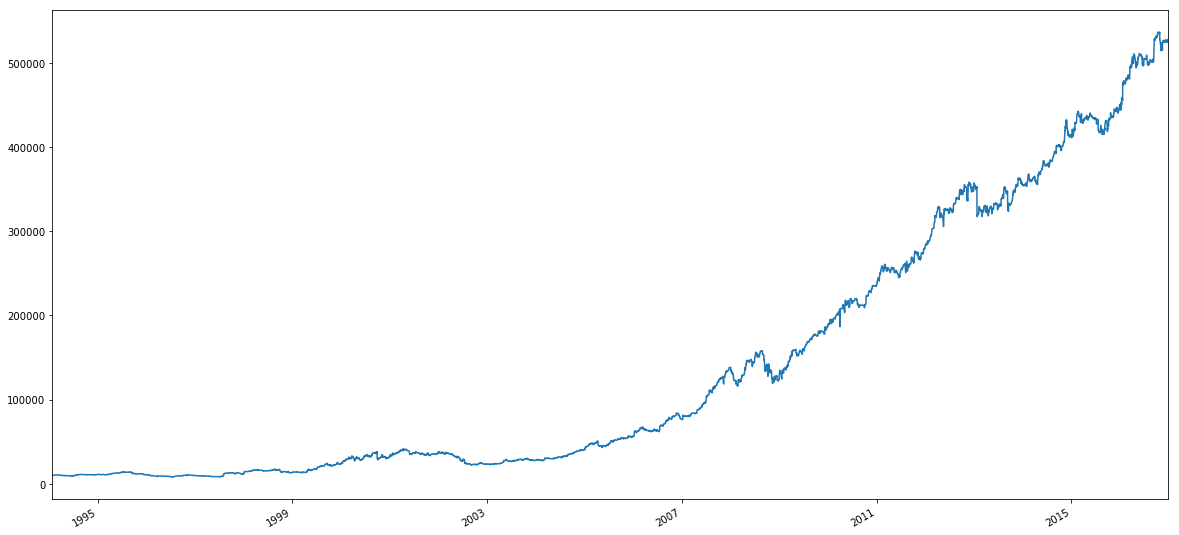

In [59]:
total_value.plot()

In [60]:
total_value[-1]

526275.38000000082

In [61]:
print(total_value.shape)
total_value.head()

(5771,)


1994-01-28    10000.00
1994-01-31     9669.44
1994-02-01     9685.96
1994-02-02     9628.99
1994-02-03     9743.23
dtype: float64

In [62]:
total_value.index[0]

Timestamp('1994-01-28 00:00:00')

In [63]:
initial_date = total_value.index[0]
compare_results = data_df.loc[initial_date:, 'Close'].copy()

In [64]:
compare_results.shape

(5771,)

In [65]:
compare_results.name='AAPL'
compare_results_df = pd.DataFrame(compare_results)
compare_results_df['portfolio'] = total_value
compare_results_df.head()

,AAPL,portfolio
date,,
1994-01-28,1.21,10000.00
1994-01-31,1.17,9669.44
1994-02-01,1.19,9685.96
1994-02-02,1.18,9628.99
1994-02-03,1.20,9743.23


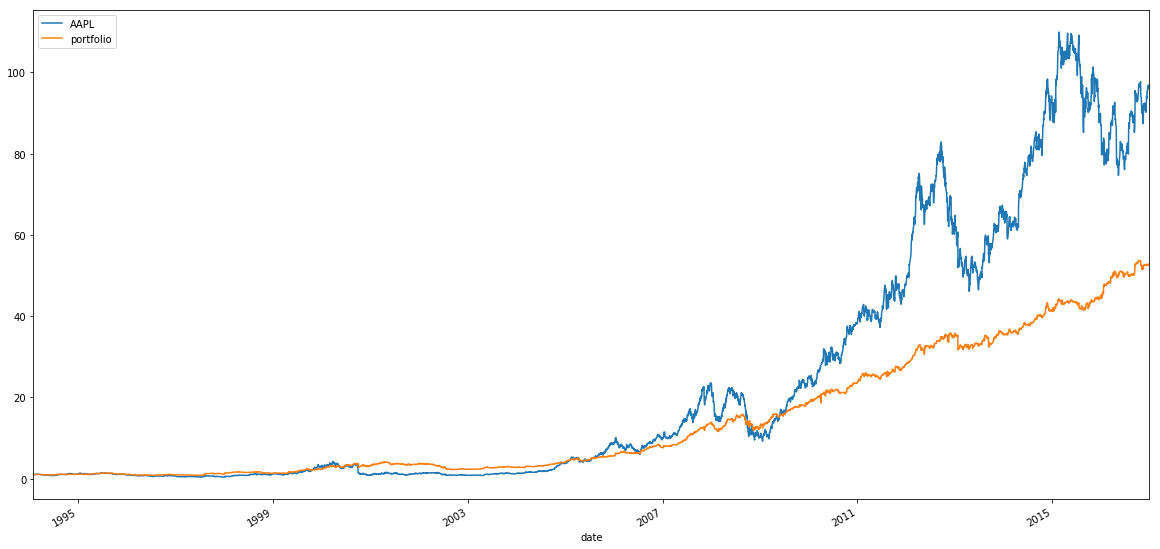

In [66]:
std_comp_df = compare_results_df / compare_results_df.iloc[0]
std_comp_df.plot()

In [67]:
value_eval(pd.DataFrame(compare_results_df['AAPL']))

(0.66696407892698417,
 94.719008264462801,
 0.0012196011129682511,
 0.029027901311892094,
 115.81999999999999)

In [68]:
a_dict = {'col1':{'index1':89, 'index2':98}, 'col2':{'index1':90, 'index2':80}}

In [69]:
pd.DataFrame(a_dict)

,col1,col2
index1,89,90
index2,98,80


In [70]:
pd.DataFrame(a_dict).sum(axis=1)

index1    179
index2    178
dtype: int64